JAKIEŚ LINKI CO ZAPISAŁEM:

- https://www.youtube.com/watch?v=IFeCIbljreY
- https://www.youtube.com/results?search_query=meanshift
- https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html


## Laboratorium 8.1

## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,

- przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
- przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.


### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:

- tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
- pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:

```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).


Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---


In [1]:
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Zadanie 1

#### Zadanie 1a

Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.


In [2]:
def calculate_flow(frame1, frame2, winsize=15):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
        pyr_scale=0.5,
        levels=3,
        winsize=winsize,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255                                                      # Maximum saturation
    hsv[..., 0] = angle * 180 / np.pi / 2                                  # Hue is direction
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value is magnitude

    # converting to BGR for consistency with the input frames
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return flow, magnitude, angle, flow_bgr

In [3]:
def get_frames(file_path, skip_frames=0):

    cap = cv2.VideoCapture(file_path)
    status, frame = cap.read()

    if not status:
        raise ValueError("Failed to read the first frame from the video.")

    for _ in range(skip_frames):
        status, _ = cap.read()
        if not status:
            raise ValueError("Failed to read the frame after skipping.")

    _, frame1 = cap.read()
    _, frame2 = cap.read()

    cap.release()

    return frame1, frame2

In [4]:
file_path = 'data/dane8/kick.mp4'
skip_frames = 30

frame1, frame2 = get_frames(file_path, skip_frames)

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

flow, magnitude, angle, flow_bgr = calculate_flow(frame1, frame2)

ic(gray1.shape); ic(gray2.shape); ic(flow.shape); ic(magnitude.shape); ic(angle.shape);

ic| gray1.shape: (480, 854)
ic| gray2.shape: (480, 854)
ic| flow.shape: (480, 854, 2)
ic| magnitude.shape: (480, 854)
ic| angle.shape: (480, 854)


In [5]:
def plot_flow(frame1, frame2, magnitude, flow_bgr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    
    axes[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    axes[0].set_title('First Frame')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Second Frame')
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB))
    axes[2].set_title('HSV Flow Visualization')
    axes[2].axis('off')

    im = axes[3].imshow(magnitude, cmap='jet')
    plt.colorbar(im, ax=axes[3], orientation='vertical', fraction=0.046, pad=0.04)
    axes[3].set_title('Magnitude')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()


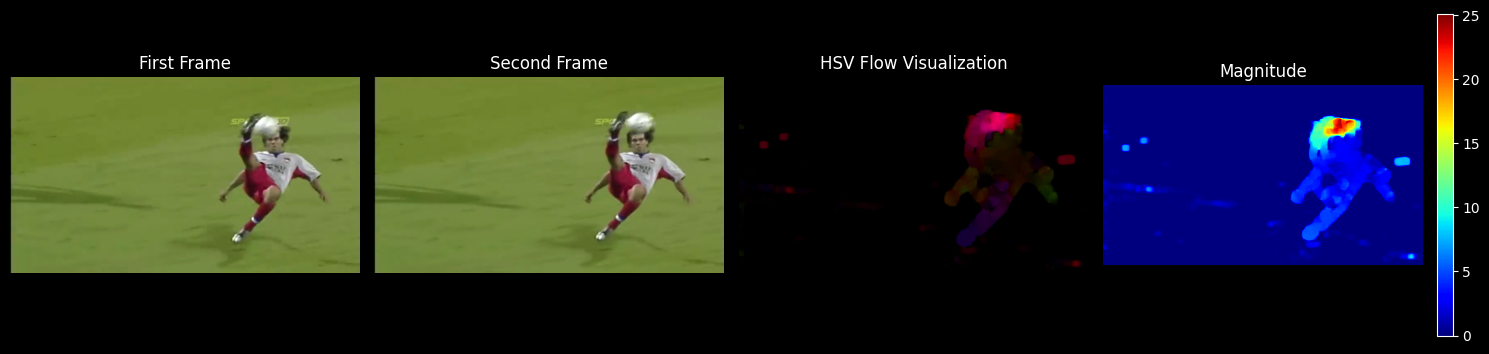

In [6]:
plot_flow(frame1, frame2, magnitude, flow_bgr)

#### Zadanie 1b

Zbadaj wpływ parametru `winsize` na działanie metody.


In [7]:
def plot_winsizes(frame1, frame2, winsizes):
    n_cols = len(winsizes) // 2
    fig, axes = plt.subplots(4, n_cols, figsize=(5*n_cols, 12))
    
    flows = [calculate_flow(frame1, frame2, winsize) for winsize in winsizes]
    
    magnitudes = np.array([flow[1] for flow in flows])
    vmin = magnitudes.min()
    vmax = magnitudes.max()
    
    for row in range(2):
        for col in range(n_cols):
            idx = row * n_cols + col
            winsize = winsizes[idx]
            _, magnitude, _, flow_bgr = flows[idx]
            
            magnitude_normalized = (magnitude - vmin) / (vmax - vmin)
            
            mag_ax = axes[row*2, col]
            im = mag_ax.imshow(magnitude_normalized, cmap='jet')
            mag_ax.set_title(f'Magnitude (winsize={winsize})')
            mag_ax.axis('off')
            
            hsv_ax = axes[row*2 + 1, col]
            hsv_ax.imshow(cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB))
            hsv_ax.axis('off')
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.subplots_adjust(right=0.9)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_76592/445391086.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


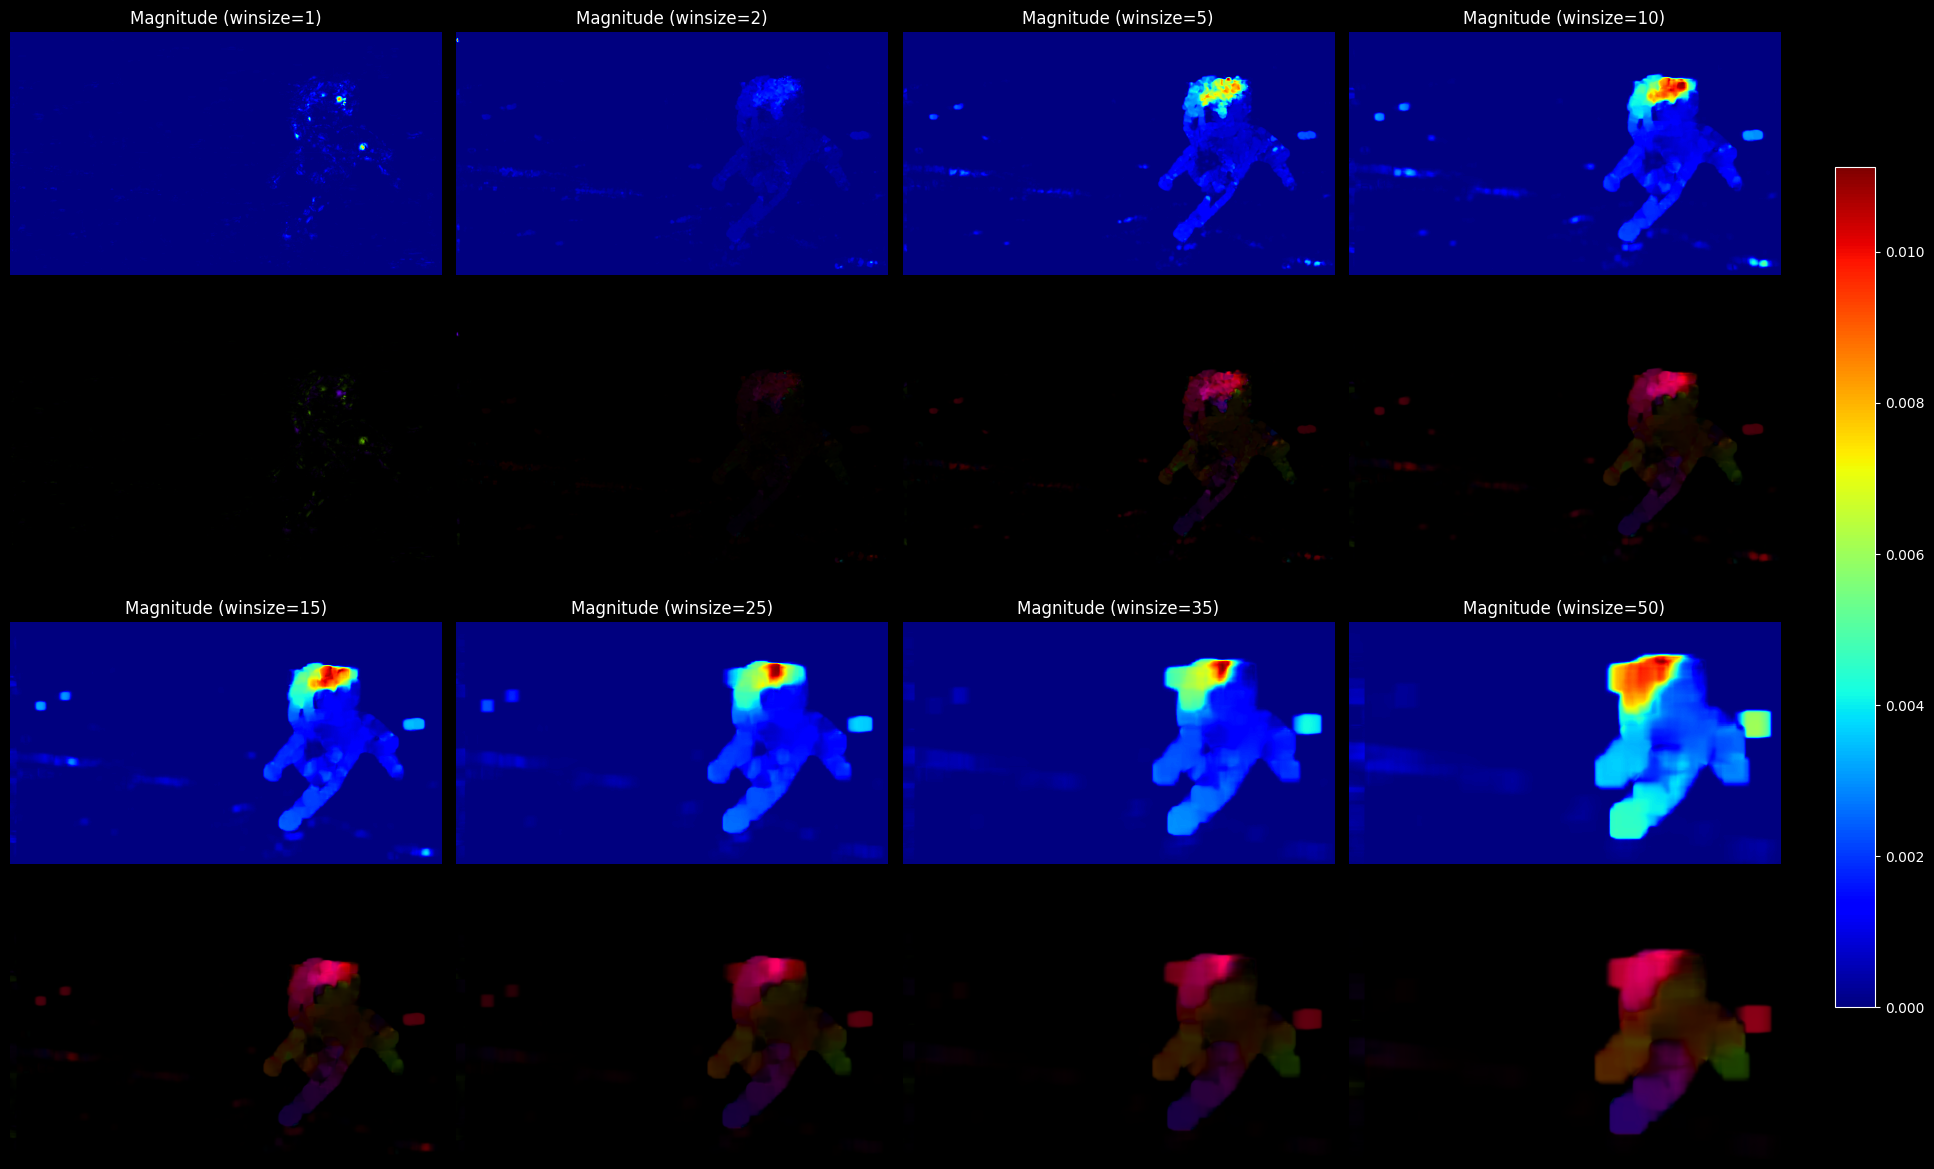

In [8]:
winsizes = [1, 2, 5, 10, 15, 25, 35, 50]

plot_winsizes(frame1, frame2, winsizes)

Komentarz 1:

...


---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
_Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?_


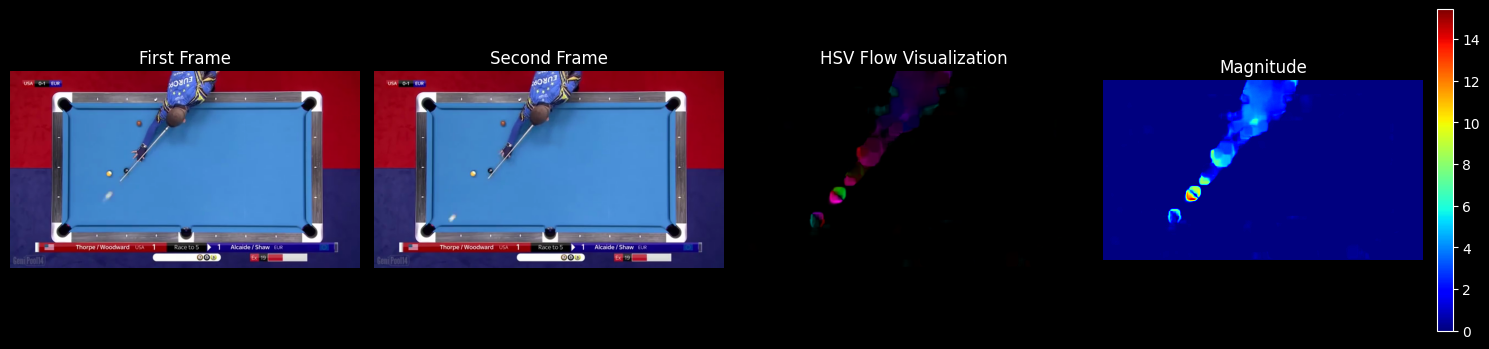

In [9]:
file_path = 'data/dane8/shot.mp4'
skip_frames = 20

frame1, frame2 = get_frames(file_path, skip_frames)

flow, magnitude, angle, flow_bgr = calculate_flow(frame1, frame2)

plot_flow(frame1, frame2, magnitude, flow_bgr)

Komentarz 2:

...


### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).


In [10]:
def segment_moving_objects(frame1, frame2, threshold=1.0, winsize=15):
    _, magnitude, _, _ = calculate_flow(frame1, frame2, winsize)
    
    # Magnitude threshold
    motion_mask = magnitude > threshold
    
    # Morphological operations
    kernel = np.ones((5,5), np.uint8)
    motion_mask = motion_mask.astype(np.uint8)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel)
    
    segmented = frame2.copy()
    segmented[motion_mask == 0] = frame2[motion_mask == 0] * 0.2
    return motion_mask, segmented

In [11]:
def plot_segmentation(frame1, frame2, thresholds):
    fig, axes = plt.subplots(len(thresholds), 3, figsize=(15, 3*len(thresholds)))

    for i, threshold in enumerate(thresholds):
        mask, segmented = segment_moving_objects(frame1, frame2, threshold=threshold)
        
        axes[i,0].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
        axes[i,0].axis('off')
        
        axes[i,1].imshow(mask, cmap='gray')
        axes[i,1].set_title(f'Binary Mask (magnitude th={threshold})')
        axes[i,1].axis('off')
        
        axes[i,2].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
        axes[i,2].axis('off')

    plt.tight_layout()
    plt.show()

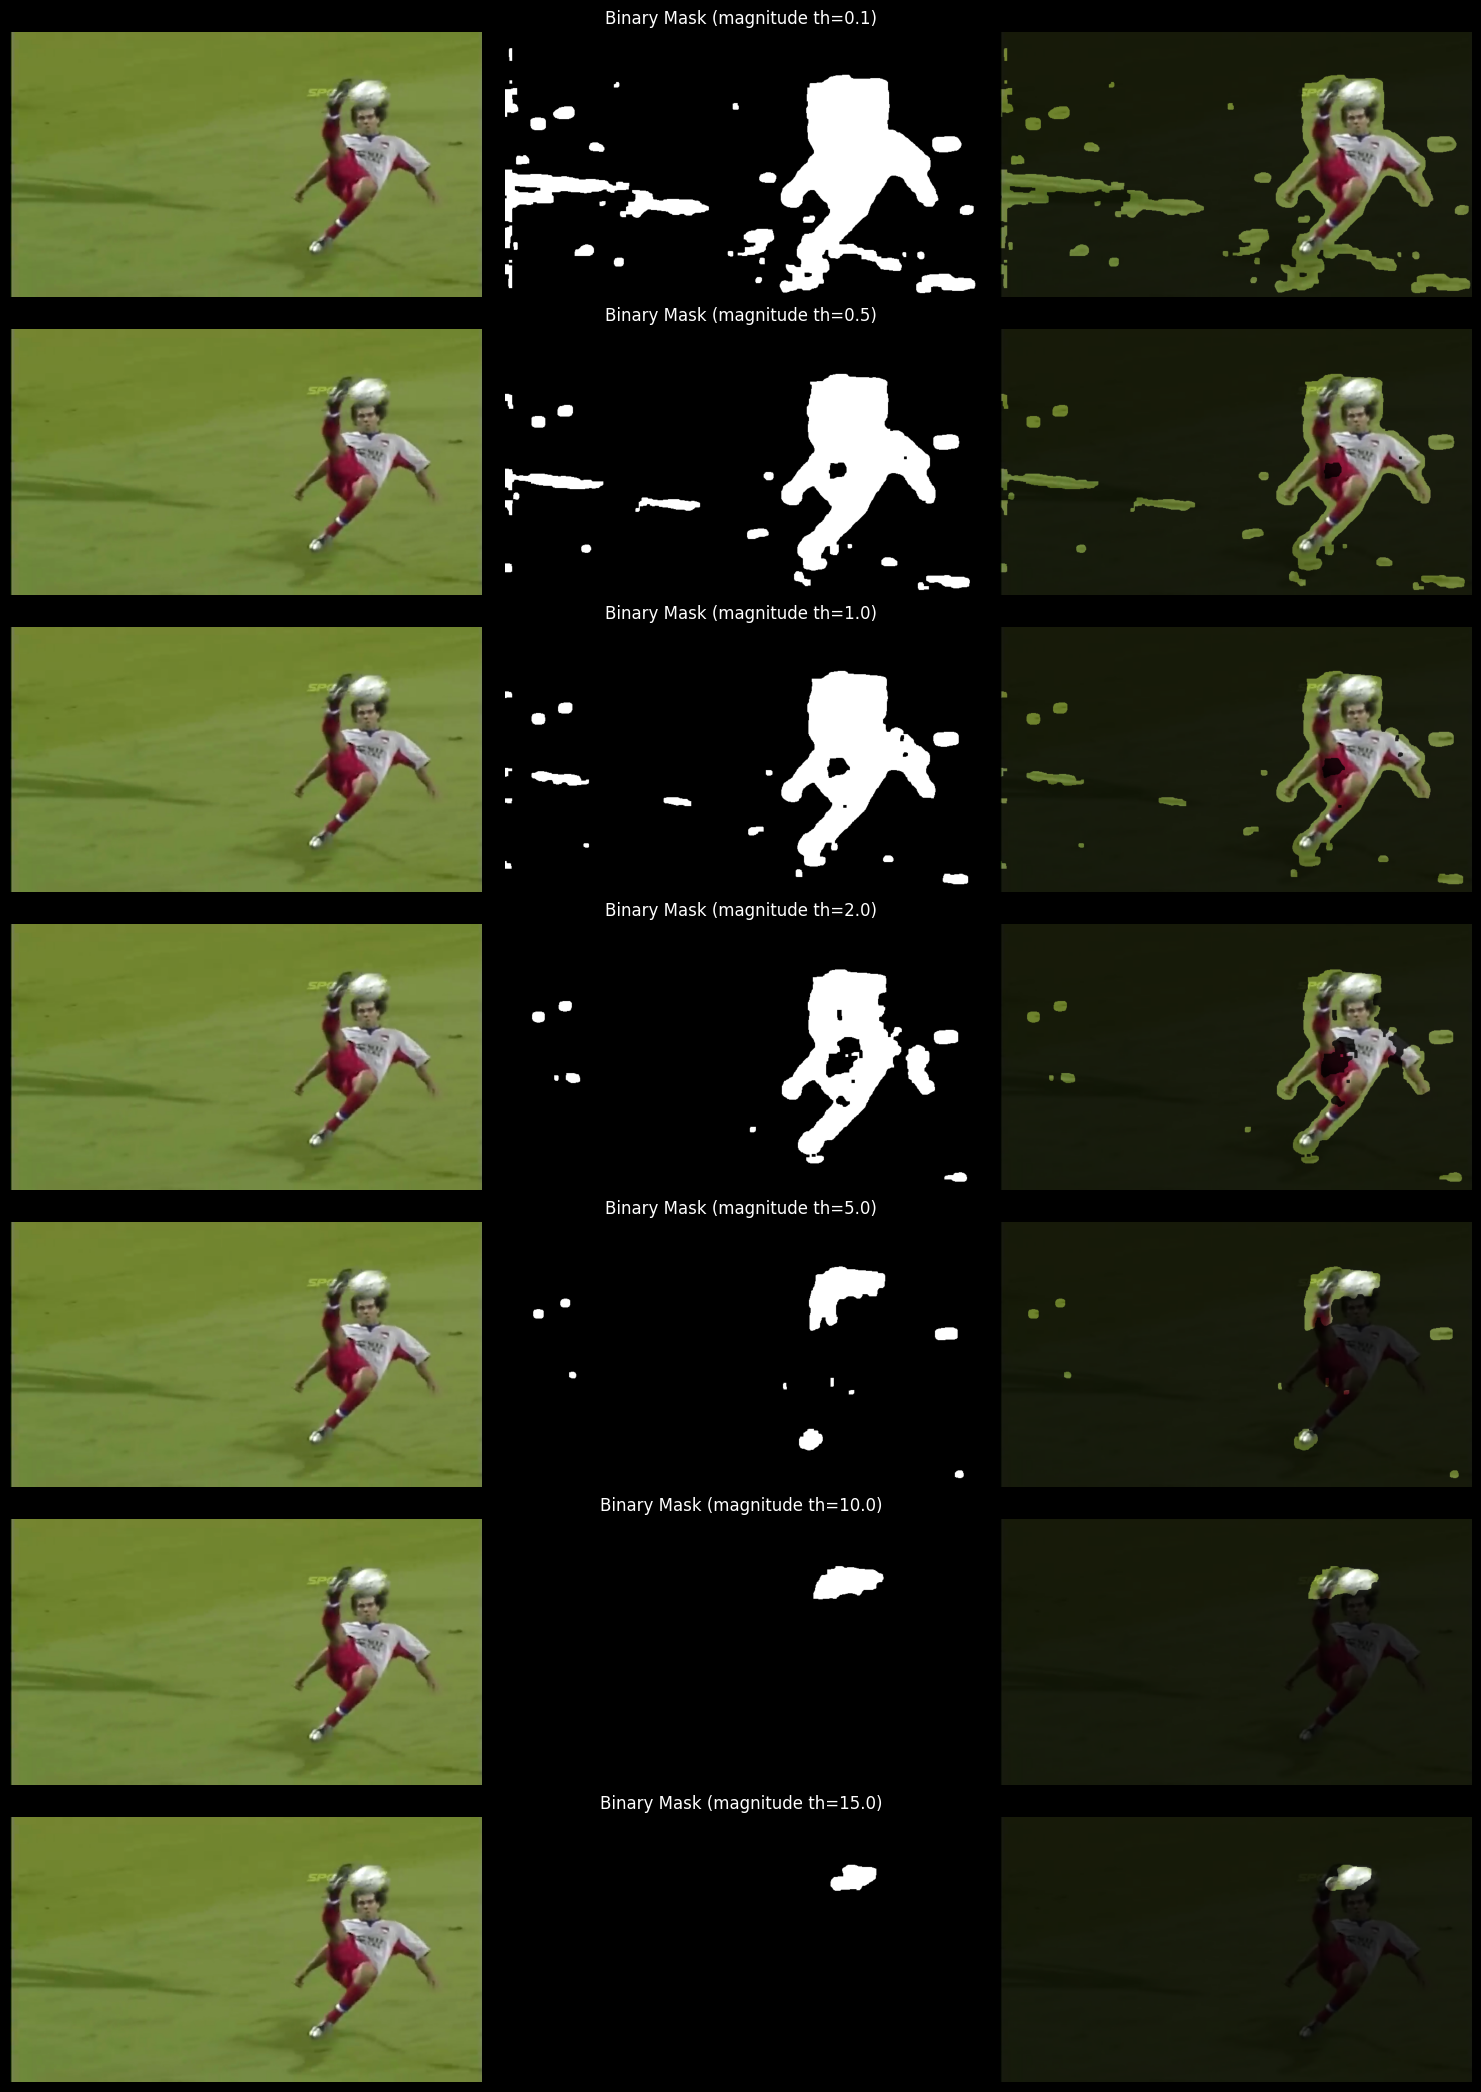

In [12]:
file_path = 'data/dane8/kick.mp4'
skip_frames = 30
frame1, frame2 = get_frames(file_path, skip_frames)

thresholds = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0]

plot_segmentation(frame1, frame2, thresholds)